## Importing all the libraries required for the analysis

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import ShuffleSplit,train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from scipy import stats
from scipy.stats import norm, skew
import folium
from mpl_toolkits.basemap import Basemap
from pandas.core import datetools

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
import os
print(os.listdir("../input"))

['raw_census_tracts_in_2010.csv', 'Census_Tracts_in_2010.dbf', 'raw_residential_data.csv', 'Census_Tracts_in_2010.shp', 'Census_Tracts_in_2010.shx', 'raw_condominium_data.csv', 'raw_address_points.csv', 'DC_Properties.csv']


In [6]:
dc = pd.read_csv("../input/DC_Properties.csv")
dc.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (18,19,20,21,22,23,24,33,34,35,37,43,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,PRICE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,SOURCE,CMPLX_NUM,LIVING_GBA,FULLADDRESS,CITY,STATE,ZIPCODE,NATIONALGRID,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT
0,0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,1972,3.0,2003-11-25 00:00:00,1095000.0,Q,1,2522.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Metal- Sms,Hardwood,2.0,5,24,1680,2018-07-22 18:01:43,Residential,NaN,NaN,1748 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23061 09289,38.914680,-77.040832,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
1,1,3,1,Warm Cool,Y,2.0,11,5,1898.0,2007.0,1972,3.0,2000-08-17 00:00:00,NaN,U,1,2567.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,2.0,4,24,1680,2018-07-22 18:01:43,Residential,NaN,NaN,1746 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23067 09289,38.914683,-77.040764,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
2,2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,1984,3.0,2016-06-21 00:00:00,2100000.0,Q,3,2522.0,1,3 Story,Row Inside,Very Good,Very Good,Common Brick,Built Up,Hardwood,2.0,4,24,1680,2018-07-22 18:01:43,Residential,NaN,NaN,1744 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23074 09289,38.914684,-77.040678,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
3,3,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,1984,3.0,2006-07-12 00:00:00,1602000.0,Q,1,2484.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,2.0,3,24,1680,2018-07-22 18:01:43,Residential,NaN,NaN,1742 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23078 09288,38.914683,-77.040629,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
4,4,2,1,Warm Cool,Y,1.0,11,3,1913.0,2012.0,1985,3.0,NaN,NaN,U,1,5255.0,1,3 Story,Semi-Detached,Very Good,Good,Common Brick,Neopren,Hardwood,1.0,0,13,2032,2018-07-22 18:01:43,Residential,NaN,NaN,1804 NEW HAMPSHIRE AVENUE NW,WASHINGTON,DC,20009.0,18S UJ 23188 09253,38.914383,-77.039361,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW


In [7]:
dc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158957 entries, 0 to 158956
Data columns (total 49 columns):
Unnamed: 0            158957 non-null int64
BATHRM                158957 non-null int64
HF_BATHRM             158957 non-null int64
HEAT                  158957 non-null object
AC                    158957 non-null object
NUM_UNITS             106696 non-null float64
ROOMS                 158957 non-null int64
BEDRM                 158957 non-null int64
AYB                   158686 non-null float64
YR_RMDL               80928 non-null float64
EYB                   158957 non-null int64
STORIES               106652 non-null float64
SALEDATE              132187 non-null object
PRICE                 98216 non-null float64
QUALIFIED             158957 non-null object
SALE_NUM              158957 non-null int64
GBA                   106696 non-null float64
BLDG_NUM              158957 non-null int64
STYLE                 106696 non-null object
STRUCT                106696 non-null 

In [8]:
print(dc.isnull().sum())

Unnamed: 0                 0
BATHRM                     0
HF_BATHRM                  0
HEAT                       0
AC                         0
NUM_UNITS              52261
ROOMS                      0
BEDRM                      0
AYB                      271
YR_RMDL                78029
EYB                        0
STORIES                52305
SALEDATE               26770
PRICE                  60741
QUALIFIED                  0
SALE_NUM                   0
GBA                    52261
BLDG_NUM                   0
STYLE                  52261
STRUCT                 52261
GRADE                  52261
CNDTN                  52261
EXTWALL                52261
ROOF                   52261
INTWALL                52261
KITCHENS               52262
FIREPLACES                 0
USECODE                    0
LANDAREA                   0
GIS_LAST_MOD_DTTM          0
SOURCE                     0
CMPLX_NUM             106696
LIVING_GBA            106696
FULLADDRESS            52917
CITY          

## Calculating the missing value percentage in each column

In [9]:
dc_na = (dc.isnull().sum() / len(dc)) * 100
dc_na = dc_na.drop(dc_na[dc_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing %' :dc_na})
missing_data.head(20)

,Missing %
CMPLX_NUM,67.122555
LIVING_GBA,67.122555
YR_RMDL,49.088118
PRICE,38.212221
FULLADDRESS,33.290135
NATIONALGRID,33.283215
CENSUS_BLOCK,33.283215
CITY,33.283215
STATE,33.283215
STORIES,32.905125


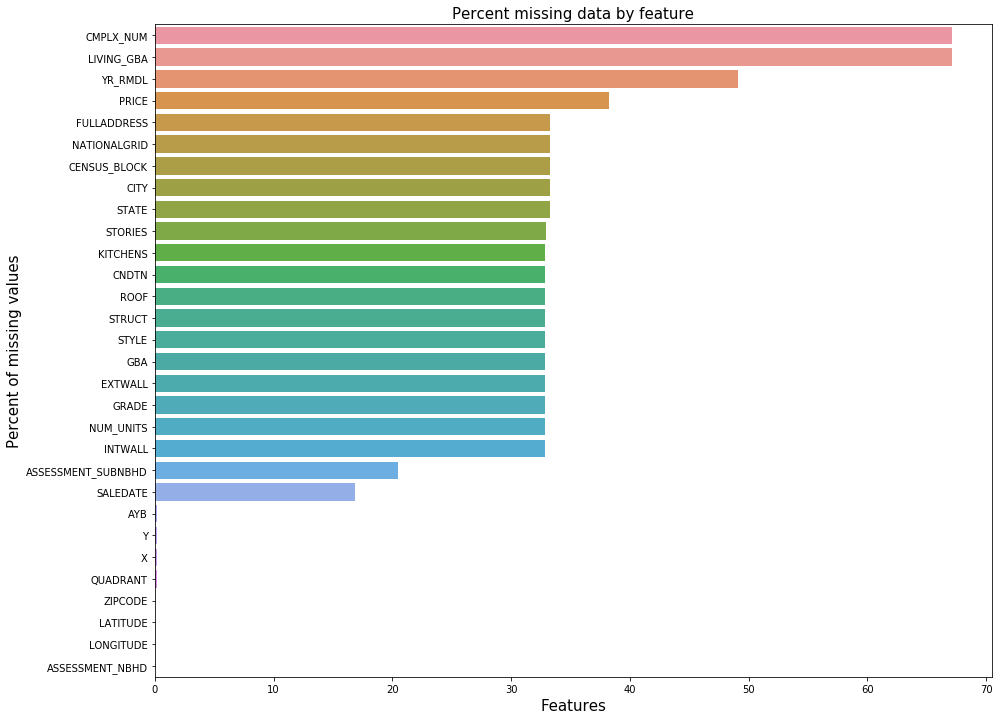

In [10]:
f, ax = plt.subplots(figsize=(15, 12))
sns.barplot(y=dc_na.index, x=dc_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
plt.show()

## Plotting the location using basemap and Folium map

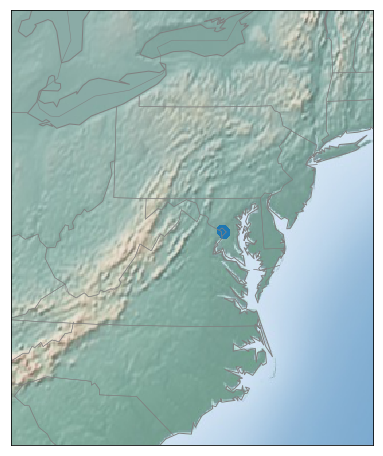

In [11]:
lat = dc['LATITUDE'].values
lon = dc['LONGITUDE'].values

# 1. Draw the map background
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='l', 
            lat_0=39, lon_0=-78,
            width=1E6, height=1.2E6)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter lat and long values

m.scatter(lon, lat, latlon=True,
          cmap='Reds', alpha=0.5)
plt.show()

In [12]:
locations = dc[['LATITUDE', 'LONGITUDE']]
locationlist = locations.values.tolist()
print(len(locationlist))
print(locationlist[1])
map = folium.Map(location=[38.9146833, -77.04076447], zoom_start=12)
folium.Marker(locationlist[1]).add_to(map)
map

158957
[38.9146833, -77.04076447]


### Commented because it is taking a huge time to execute marking 100k  records on the folium map)

In [13]:
# map = folium.Map(location=[38.9146833, -77.04076447], zoom_start=12)
# for point in range(0, len(locationlist)):
#    folium.Marker(locationlist[point]).add_to(map)
# map    

In [14]:
dc_clean=dc
dc_clean.head()

,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,PRICE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,SOURCE,CMPLX_NUM,LIVING_GBA,FULLADDRESS,CITY,STATE,ZIPCODE,NATIONALGRID,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT
0,0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,1972,3.0,2003-11-25 00:00:00,1095000.0,Q,1,2522.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Metal- Sms,Hardwood,2.0,5,24,1680,2018-07-22 18:01:43,Residential,NaN,NaN,1748 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23061 09289,38.914680,-77.040832,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
1,1,3,1,Warm Cool,Y,2.0,11,5,1898.0,2007.0,1972,3.0,2000-08-17 00:00:00,NaN,U,1,2567.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,2.0,4,24,1680,2018-07-22 18:01:43,Residential,NaN,NaN,1746 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23067 09289,38.914683,-77.040764,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
2,2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,1984,3.0,2016-06-21 00:00:00,2100000.0,Q,3,2522.0,1,3 Story,Row Inside,Very Good,Very Good,Common Brick,Built Up,Hardwood,2.0,4,24,1680,2018-07-22 18:01:43,Residential,NaN,NaN,1744 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23074 09289,38.914684,-77.040678,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
3,3,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,1984,3.0,2006-07-12 00:00:00,1602000.0,Q,1,2484.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,2.0,3,24,1680,2018-07-22 18:01:43,Residential,NaN,NaN,1742 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23078 09288,38.914683,-77.040629,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
4,4,2,1,Warm Cool,Y,1.0,11,3,1913.0,2012.0,1985,3.0,NaN,NaN,U,1,5255.0,1,3 Story,Semi-Detached,Very Good,Good,Common Brick,Neopren,Hardwood,1.0,0,13,2032,2018-07-22 18:01:43,Residential,NaN,NaN,1804 NEW HAMPSHIRE AVENUE NW,WASHINGTON,DC,20009.0,18S UJ 23188 09253,38.914383,-77.039361,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW


# Missing Value Treatment

In [15]:
dc_clean=dc_clean.drop(['NATIONALGRID','ASSESSMENT_SUBNBHD','CENSUS_BLOCK','X','Y','QUADRANT'], axis=1)

In [16]:
dc_clean.NUM_UNITS[dc_clean.NUM_UNITS.isnull()] =  dc_clean.NUM_UNITS.mode().iloc[0]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
dc_clean.loc[dc_clean['YR_RMDL'].isnull(), 'YR_RMDL'] = dc_clean['EYB']

In [18]:
dc_clean.loc[dc_clean['AYB'].isnull(), 'AYB'] = dc_clean['EYB']

In [19]:
dc_clean.STORIES=dc_clean.STORIES.round()
dc_clean.STORIES[dc_clean.STORIES.isnull()] =  dc_clean.STORIES.mode().iloc[0]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
print(dc_clean.GBA.describe())
dc_clean.GBA[dc_clean.GBA.isnull()] =  dc_clean.GBA.mean()

count    106696.000000
mean       1714.539889
std         880.677860
min           0.000000
25%        1190.000000
50%        1480.000000
75%        1966.000000
max       45384.000000
Name: GBA, dtype: float64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
dc_clean.STYLE[dc_clean.STYLE.isnull()] =  dc_clean.STYLE.mode().iloc[0]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
dc_clean.STRUCT[dc_clean.STRUCT.isnull()] =  dc_clean.STRUCT.mode().iloc[0]
dc_clean.GRADE[dc_clean.GRADE.isnull()] =  dc_clean.GRADE.mode().iloc[0]
dc_clean.CNDTN[dc_clean.CNDTN.isnull()] =  dc_clean.CNDTN.mode().iloc[0]
dc_clean.EXTWALL[dc_clean.EXTWALL.isnull()] =  dc_clean.EXTWALL.mode().iloc[0]
dc_clean.ROOF[dc_clean.ROOF.isnull()] =  dc_clean.ROOF.mode().iloc[0]
dc_clean.INTWALL[dc_clean.INTWALL.isnull()] =  dc_clean.INTWALL.mode().iloc[0]
dc_clean.KITCHENS[dc_clean.KITCHENS.isnull()] =  dc_clean.KITCHENS.mode().iloc[0]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-p

In [23]:
print(dc_clean.LIVING_GBA.describe())
dc_clean.LIVING_GBA[dc_clean.LIVING_GBA.isnull()] =  dc_clean.LIVING_GBA.median()

count    52261.000000
mean       888.834542
std        420.185822
min          0.000000
25%        616.000000
50%        783.000000
75%       1060.000000
max       8553.000000
Name: LIVING_GBA, dtype: float64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
dc_clean['CMPLX_NUM1'] = dc_clean['FULLADDRESS'].str[0:4]
dc_clean.loc[dc_clean['CMPLX_NUM'].isnull(), 'CMPLX_NUM'] = dc_clean['CMPLX_NUM1']
dc_clean.CMPLX_NUM[dc_clean.CMPLX_NUM.isnull()] =  dc_clean.CMPLX_NUM.mode().iloc[0]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
dc_clean.CITY[dc_clean.CITY.isnull()] =  'WASHINGTON'
dc_clean.STATE[dc_clean.STATE.isnull()] =  'DC'

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
dc_clean.LATITUDE[dc_clean.LATITUDE.isnull()] =  38.9146833
dc_clean.LONGITUDE[dc_clean.LONGITUDE.isnull()] =  -77.04076447

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
dc_clean=dc_clean.drop(['FULLADDRESS','CMPLX_NUM1'], axis=1)

In [28]:
dc_clean.head()

,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,PRICE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,SOURCE,CMPLX_NUM,LIVING_GBA,CITY,STATE,ZIPCODE,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,CENSUS_TRACT,WARD,SQUARE
0,0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,1972,3.0,2003-11-25 00:00:00,1095000.0,Q,1,2522.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Metal- Sms,Hardwood,2.0,5,24,1680,2018-07-22 18:01:43,Residential,1748,783.0,WASHINGTON,DC,20009.0,38.914680,-77.040832,Old City 2,4201.0,Ward 2,152
1,1,3,1,Warm Cool,Y,2.0,11,5,1898.0,2007.0,1972,3.0,2000-08-17 00:00:00,NaN,U,1,2567.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,2.0,4,24,1680,2018-07-22 18:01:43,Residential,1746,783.0,WASHINGTON,DC,20009.0,38.914683,-77.040764,Old City 2,4201.0,Ward 2,152
2,2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,1984,3.0,2016-06-21 00:00:00,2100000.0,Q,3,2522.0,1,3 Story,Row Inside,Very Good,Very Good,Common Brick,Built Up,Hardwood,2.0,4,24,1680,2018-07-22 18:01:43,Residential,1744,783.0,WASHINGTON,DC,20009.0,38.914684,-77.040678,Old City 2,4201.0,Ward 2,152
3,3,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,1984,3.0,2006-07-12 00:00:00,1602000.0,Q,1,2484.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,2.0,3,24,1680,2018-07-22 18:01:43,Residential,1742,783.0,WASHINGTON,DC,20009.0,38.914683,-77.040629,Old City 2,4201.0,Ward 2,152
4,4,2,1,Warm Cool,Y,1.0,11,3,1913.0,2012.0,1985,3.0,NaN,NaN,U,1,5255.0,1,3 Story,Semi-Detached,Very Good,Good,Common Brick,Neopren,Hardwood,1.0,0,13,2032,2018-07-22 18:01:43,Residential,1804,783.0,WASHINGTON,DC,20009.0,38.914383,-77.039361,Old City 2,4201.0,Ward 2,152


In [29]:
dc_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158957 entries, 0 to 158956
Data columns (total 42 columns):
Unnamed: 0           158957 non-null int64
BATHRM               158957 non-null int64
HF_BATHRM            158957 non-null int64
HEAT                 158957 non-null object
AC                   158957 non-null object
NUM_UNITS            158957 non-null float64
ROOMS                158957 non-null int64
BEDRM                158957 non-null int64
AYB                  158957 non-null float64
YR_RMDL              158957 non-null float64
EYB                  158957 non-null int64
STORIES              158957 non-null float64
SALEDATE             132187 non-null object
PRICE                98216 non-null float64
QUALIFIED            158957 non-null object
SALE_NUM             158957 non-null int64
GBA                  158957 non-null float64
BLDG_NUM             158957 non-null int64
STYLE                158957 non-null object
STRUCT               158957 non-null object
GRADE       

In [30]:
unknown_data=dc_clean[dc_clean.PRICE.isnull()]

In [31]:
unknown_data.head()

,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,PRICE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,SOURCE,CMPLX_NUM,LIVING_GBA,CITY,STATE,ZIPCODE,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,CENSUS_TRACT,WARD,SQUARE
1,1,3,1,Warm Cool,Y,2.0,11,5,1898.0,2007.0,1972,3.0,2000-08-17 00:00:00,NaN,U,1,2567.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,2.0,4,24,1680,2018-07-22 18:01:43,Residential,1746,783.0,WASHINGTON,DC,20009.0,38.914683,-77.040764,Old City 2,4201.0,Ward 2,152
4,4,2,1,Warm Cool,Y,1.0,11,3,1913.0,2012.0,1985,3.0,NaN,NaN,U,1,5255.0,1,3 Story,Semi-Detached,Very Good,Good,Common Brick,Neopren,Hardwood,1.0,0,13,2032,2018-07-22 18:01:43,Residential,1804,783.0,WASHINGTON,DC,20009.0,38.914383,-77.039361,Old City 2,4201.0,Ward 2,152
6,6,1,0,Warm Cool,Y,2.0,5,2,1917.0,1988.0,1957,2.0,2011-05-02 00:00:00,NaN,U,1,1260.0,1,2 Story,Row Inside,Above Average,Average,Common Brick,Metal- Sms,Hardwood,2.0,0,24,1261,2018-07-22 18:01:43,Residential,1769,783.0,WASHINGTON,DC,20009.0,38.914983,-77.041055,Old City 2,4201.0,Ward 2,152
9,9,1,1,Hot Water Rad,Y,1.0,6,2,1908.0,1979.0,1950,2.0,2008-12-05 00:00:00,NaN,U,1,1590.0,1,2 Story,Row Inside,Good Quality,Average,Common Brick,Built Up,Hardwood,1.0,0,11,1424,2018-07-22 18:01:43,Residential,1733,783.0,WASHINGTON,DC,20009.0,38.915015,-77.040081,Old City 2,4201.0,Ward 2,152
10,10,3,0,Forced Air,N,3.0,12,5,1890.0,1950.0,1954,3.0,NaN,NaN,U,1,2748.0,1,3 Story,Row Inside,Very Good,Fair,Common Brick,Metal- Sms,Hardwood,3.0,0,24,1360,2018-07-22 18:01:43,Residential,1755,783.0,WASHINGTON,DC,20009.0,38.914980,-77.040760,Old City 2,4201.0,Ward 2,152


In [32]:
dc_clean = dc_clean[dc_clean.PRICE.notnull()]
dc_clean.head()

,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,PRICE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,SOURCE,CMPLX_NUM,LIVING_GBA,CITY,STATE,ZIPCODE,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,CENSUS_TRACT,WARD,SQUARE
0,0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,1972,3.0,2003-11-25 00:00:00,1095000.0,Q,1,2522.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Metal- Sms,Hardwood,2.0,5,24,1680,2018-07-22 18:01:43,Residential,1748,783.0,WASHINGTON,DC,20009.0,38.914680,-77.040832,Old City 2,4201.0,Ward 2,152
2,2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,1984,3.0,2016-06-21 00:00:00,2100000.0,Q,3,2522.0,1,3 Story,Row Inside,Very Good,Very Good,Common Brick,Built Up,Hardwood,2.0,4,24,1680,2018-07-22 18:01:43,Residential,1744,783.0,WASHINGTON,DC,20009.0,38.914684,-77.040678,Old City 2,4201.0,Ward 2,152
3,3,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,1984,3.0,2006-07-12 00:00:00,1602000.0,Q,1,2484.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,2.0,3,24,1680,2018-07-22 18:01:43,Residential,1742,783.0,WASHINGTON,DC,20009.0,38.914683,-77.040629,Old City 2,4201.0,Ward 2,152
5,5,3,2,Hot Water Rad,Y,1.0,10,5,1913.0,1972.0,1972,4.0,2010-02-26 00:00:00,1950000.0,Q,1,5344.0,1,4 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,1.0,4,11,2196,2018-07-22 18:01:43,Residential,1709,783.0,WASHINGTON,DC,20009.0,38.914331,-77.039715,Old City 2,4201.0,Ward 2,152
7,7,3,1,Hot Water Rad,Y,2.0,8,4,1906.0,2011.0,1972,3.0,2011-09-29 00:00:00,1050000.0,Q,1,2401.0,1,3 Story,Row Inside,Very Good,Average,Common Brick,Metal- Sms,Hardwood,2.0,1,24,1627,2018-07-22 18:01:43,Residential,1746,783.0,WASHINGTON,DC,20009.0,38.915408,-77.040129,Old City 2,4201.0,Ward 2,152


In [33]:
dc_clean.rename(columns={"Unnamed: 0": "id"}, inplace= True)
dc_clean.set_index("id", inplace = True)

In [34]:
dc_clean.head()

,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,PRICE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,SOURCE,CMPLX_NUM,LIVING_GBA,CITY,STATE,ZIPCODE,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,CENSUS_TRACT,WARD,SQUARE
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,1972,3.0,2003-11-25 00:00:00,1095000.0,Q,1,2522.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Metal- Sms,Hardwood,2.0,5,24,1680,2018-07-22 18:01:43,Residential,1748,783.0,WASHINGTON,DC,20009.0,38.914680,-77.040832,Old City 2,4201.0,Ward 2,152
2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,1984,3.0,2016-06-21 00:00:00,2100000.0,Q,3,2522.0,1,3 Story,Row Inside,Very Good,Very Good,Common Brick,Built Up,Hardwood,2.0,4,24,1680,2018-07-22 18:01:43,Residential,1744,783.0,WASHINGTON,DC,20009.0,38.914684,-77.040678,Old City 2,4201.0,Ward 2,152
3,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,1984,3.0,2006-07-12 00:00:00,1602000.0,Q,1,2484.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,2.0,3,24,1680,2018-07-22 18:01:43,Residential,1742,783.0,WASHINGTON,DC,20009.0,38.914683,-77.040629,Old City 2,4201.0,Ward 2,152
5,3,2,Hot Water Rad,Y,1.0,10,5,1913.0,1972.0,1972,4.0,2010-02-26 00:00:00,1950000.0,Q,1,5344.0,1,4 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,1.0,4,11,2196,2018-07-22 18:01:43,Residential,1709,783.0,WASHINGTON,DC,20009.0,38.914331,-77.039715,Old City 2,4201.0,Ward 2,152
7,3,1,Hot Water Rad,Y,2.0,8,4,1906.0,2011.0,1972,3.0,2011-09-29 00:00:00,1050000.0,Q,1,2401.0,1,3 Story,Row Inside,Very Good,Average,Common Brick,Metal- Sms,Hardwood,2.0,1,24,1627,2018-07-22 18:01:43,Residential,1746,783.0,WASHINGTON,DC,20009.0,38.915408,-77.040129,Old City 2,4201.0,Ward 2,152


In [35]:
unknown_data.rename(columns={"Unnamed: 0": "id"}, inplace= True)
unknown_data.set_index("id", inplace = True)
unknown_data.head()

,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,PRICE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,SOURCE,CMPLX_NUM,LIVING_GBA,CITY,STATE,ZIPCODE,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,CENSUS_TRACT,WARD,SQUARE
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3,1,Warm Cool,Y,2.0,11,5,1898.0,2007.0,1972,3.0,2000-08-17 00:00:00,NaN,U,1,2567.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,2.0,4,24,1680,2018-07-22 18:01:43,Residential,1746,783.0,WASHINGTON,DC,20009.0,38.914683,-77.040764,Old City 2,4201.0,Ward 2,152
4,2,1,Warm Cool,Y,1.0,11,3,1913.0,2012.0,1985,3.0,NaN,NaN,U,1,5255.0,1,3 Story,Semi-Detached,Very Good,Good,Common Brick,Neopren,Hardwood,1.0,0,13,2032,2018-07-22 18:01:43,Residential,1804,783.0,WASHINGTON,DC,20009.0,38.914383,-77.039361,Old City 2,4201.0,Ward 2,152
6,1,0,Warm Cool,Y,2.0,5,2,1917.0,1988.0,1957,2.0,2011-05-02 00:00:00,NaN,U,1,1260.0,1,2 Story,Row Inside,Above Average,Average,Common Brick,Metal- Sms,Hardwood,2.0,0,24,1261,2018-07-22 18:01:43,Residential,1769,783.0,WASHINGTON,DC,20009.0,38.914983,-77.041055,Old City 2,4201.0,Ward 2,152
9,1,1,Hot Water Rad,Y,1.0,6,2,1908.0,1979.0,1950,2.0,2008-12-05 00:00:00,NaN,U,1,1590.0,1,2 Story,Row Inside,Good Quality,Average,Common Brick,Built Up,Hardwood,1.0,0,11,1424,2018-07-22 18:01:43,Residential,1733,783.0,WASHINGTON,DC,20009.0,38.915015,-77.040081,Old City 2,4201.0,Ward 2,152
10,3,0,Forced Air,N,3.0,12,5,1890.0,1950.0,1954,3.0,NaN,NaN,U,1,2748.0,1,3 Story,Row Inside,Very Good,Fair,Common Brick,Metal- Sms,Hardwood,3.0,0,24,1360,2018-07-22 18:01:43,Residential,1755,783.0,WASHINGTON,DC,20009.0,38.914980,-77.040760,Old City 2,4201.0,Ward 2,152


## Creating the Dummy variable for object datatype variables

In [36]:
dc_clean = pd.get_dummies(dc_clean, prefix='HEAT_', columns=['HEAT'])
dc_clean = pd.get_dummies(dc_clean, prefix='AC_', columns=['AC'])
dc_clean = pd.get_dummies(dc_clean, prefix='QUALIFIED_', columns=['QUALIFIED'])
dc_clean = pd.get_dummies(dc_clean, prefix='STYLE_', columns=['STYLE'])
dc_clean = pd.get_dummies(dc_clean, prefix='STRUCT_', columns=['STRUCT'])
dc_clean = pd.get_dummies(dc_clean, prefix='GRADE_', columns=['GRADE'])
dc_clean = pd.get_dummies(dc_clean, prefix='CNDTN_', columns=['CNDTN'])
dc_clean = pd.get_dummies(dc_clean, prefix='EXTWALL_', columns=['EXTWALL'])
dc_clean = pd.get_dummies(dc_clean, prefix='ROOF_', columns=['ROOF'])
dc_clean = pd.get_dummies(dc_clean, prefix='INTWALL_', columns=['INTWALL'])
dc_clean = pd.get_dummies(dc_clean, prefix='SOURCE_', columns=['SOURCE'])
dc_clean = pd.get_dummies(dc_clean, prefix='WARD_', columns=['WARD'])

In [37]:
print(dc_clean.describe())

             BATHRM     HF_BATHRM      ...       WARD__Ward 7  WARD__Ward 8
count  98216.000000  98216.000000      ...       98216.000000  98216.000000
mean       1.859157      0.444541      ...           0.093926      0.063900
std        0.978321      0.576217      ...           0.291727      0.244576
min        0.000000      0.000000      ...           0.000000      0.000000
25%        1.000000      0.000000      ...           0.000000      0.000000
50%        2.000000      0.000000      ...           0.000000      0.000000
75%        2.000000      1.000000      ...           0.000000      0.000000
max       12.000000     11.000000      ...           1.000000      1.000000

[8 rows x 149 columns]


## Performing Stepwise regression to find the most significant variables

In [38]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [39]:
X = dc_clean[['BATHRM', 'HF_BATHRM', 'NUM_UNITS', 'ROOMS', 'BEDRM', 'AYB',
       'YR_RMDL', 'EYB', 'STORIES', 'SALE_NUM',
       'GBA', 'BLDG_NUM', 'KITCHENS', 'FIREPLACES', 'USECODE', 'LANDAREA',
         'LIVING_GBA',
       'ZIPCODE', 'LATITUDE', 'LONGITUDE',
       'CENSUS_TRACT', 'HEAT__Air Exchng', 'HEAT__Air-Oil',
       'HEAT__Elec Base Brd', 'HEAT__Electric Rad', 'HEAT__Evp Cool',
       'HEAT__Forced Air', 'HEAT__Gravity Furnac', 'HEAT__Hot Water Rad',
       'HEAT__Ht Pump', 'HEAT__Ind Unit', 'HEAT__No Data',
       'HEAT__Wall Furnace', 'HEAT__Warm Cool', 'HEAT__Water Base Brd',
       'AC__0', 'AC__N', 'AC__Y', 'QUALIFIED__Q', 'QUALIFIED__U',
       'STYLE__1 Story', 'STYLE__1.5 Story Fin', 'STYLE__1.5 Story Unfin',
       'STYLE__2 Story', 'STYLE__2.5 Story Fin', 'STYLE__2.5 Story Unfin',
       'STYLE__3 Story', 'STYLE__3.5 Story Fin', 'STYLE__3.5 Story Unfin',
       'STYLE__4 Story', 'STYLE__4.5 Story Fin', 'STYLE__4.5 Story Unfin',
       'STYLE__Bi-Level', 'STYLE__Default', 'STYLE__Outbuildings',
       'STYLE__Split Foyer', 'STYLE__Split Level', 'STYLE__Vacant',
       'STRUCT__Default', 'STRUCT__Multi', 'STRUCT__Row End',
       'STRUCT__Row Inside', 'STRUCT__Semi-Detached', 'STRUCT__Single',
       'STRUCT__Town End', 'STRUCT__Town Inside', 'GRADE__Above Average',
       'GRADE__Average', 'GRADE__Excellent', 'GRADE__Exceptional-A',
       'GRADE__Exceptional-B', 'GRADE__Exceptional-C',
       'GRADE__Exceptional-D', 'GRADE__Fair Quality',
       'GRADE__Good Quality', 'GRADE__Low Quality', 'GRADE__No Data',
       'GRADE__Superior', 'GRADE__Very Good', 'CNDTN__Average',
       'CNDTN__Default', 'CNDTN__Excellent', 'CNDTN__Fair', 'CNDTN__Good',
       'CNDTN__Poor', 'CNDTN__Very Good', 'EXTWALL__Adobe',
       'EXTWALL__Aluminum', 'EXTWALL__Brick Veneer',
       'EXTWALL__Brick/Siding', 'EXTWALL__Brick/Stone',
       'EXTWALL__Brick/Stucco', 'EXTWALL__Common Brick',
       'EXTWALL__Concrete', 'EXTWALL__Concrete Block', 'EXTWALL__Default',
       'EXTWALL__Face Brick', 'EXTWALL__Hardboard',
       'EXTWALL__Metal Siding', 'EXTWALL__Plywood', 'EXTWALL__SPlaster',
       'EXTWALL__Shingle', 'EXTWALL__Stone', 'EXTWALL__Stone Veneer',
       'EXTWALL__Stone/Siding', 'EXTWALL__Stone/Stucco',
       'EXTWALL__Stucco', 'EXTWALL__Stucco Block',
       'EXTWALL__Vinyl Siding', 'EXTWALL__Wood Siding', 'ROOF__Built Up',
       'ROOF__Clay Tile', 'ROOF__Comp Shingle', 'ROOF__Composition Ro',
       'ROOF__Concrete', 'ROOF__Concrete Tile', 'ROOF__Metal- Cpr',
       'ROOF__Metal- Pre', 'ROOF__Metal- Sms', 'ROOF__Neopren',
       'ROOF__Shake', 'ROOF__Shingle', 'ROOF__Slate', 'ROOF__Typical',
       'ROOF__Water Proof', 'ROOF__Wood- FS', 'INTWALL__Carpet',
       'INTWALL__Ceramic Tile', 'INTWALL__Default', 'INTWALL__Hardwood',
       'INTWALL__Hardwood/Carp', 'INTWALL__Lt Concrete',
       'INTWALL__Parquet', 'INTWALL__Resiliant', 'INTWALL__Terrazo',
       'INTWALL__Vinyl Comp', 'INTWALL__Vinyl Sheet',
       'INTWALL__Wood Floor', 'SOURCE__Condominium',
       'SOURCE__Residential', 'WARD__Ward 1', 'WARD__Ward 2',
       'WARD__Ward 3', 'WARD__Ward 4', 'WARD__Ward 5', 'WARD__Ward 6',
       'WARD__Ward 7', 'WARD__Ward 8']]
y = dc_clean['PRICE']

In [ ]:
result = stepwise_selection(X, y)
print('resulting features:')
print(result)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  WARD__Ward 3                   with p-value 0.0
Add  QUALIFIED__U                   with p-value 5.67767e-233
Add  HEAT__Ht Pump                  with p-value 1.21846e-223
Add  YR_RMDL                        with p-value 3.94122e-81
Add  QUALIFIED__Q                   with p-value 7.2739e-90
Add  EYB                            with p-value 3.99605e-28
Add  LIVING_GBA                     with p-value 7.60033e-27
Add  STRUCT__Single                 with p-value 2.86468e-22
Add  LATITUDE                       with p-value 2.01365e-21
Add  FIREPLACES                     with p-value 6.66614e-14
Add  GRADE__Very Good               with p-value 2.33774e-09
Add  GRADE__Good Quality            with p-value 6.82391e-09
Add  AYB                            with p-value 4.90773e-07
Add  GRADE__Excellent               with p-value 6.48296e-08


### Including only the significant variables

In [ ]:
X = dc_clean[['WARD__Ward 3', 'QUALIFIED__Q', 'HEAT__Ht Pump', 'YR_RMDL', 'QUALIFIED__U', 'EYB', 'LIVING_GBA',
              'STRUCT__Single', 'LATITUDE', 'FIREPLACES', 'GRADE__Very Good', 'GRADE__Good Quality', 'AYB', 
              'GRADE__Excellent', 'WARD__Ward 2', 'CENSUS_TRACT', 'LONGITUDE', 'SALE_NUM', 'WARD__Ward 4',
              'ZIPCODE', 'WARD__Ward 7', 'STYLE__3 Story', 'GRADE__Superior', 'STRUCT__Semi-Detached', 
              'GRADE__Exceptional-C','BATHRM', 'HF_BATHRM', 'NUM_UNITS', 'ROOMS', 'BEDRM']]
y = dc_clean['PRICE']

## Splitting the train and test data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8 , random_state=100)

## Correlation matrix

In [ ]:
corrmat = X_train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True,cmap = "viridis")
plt.show()

## OLS model and prediction

In [ ]:
X_train_sm = X_train 
X_train_sm = sm.add_constant(X_train_sm)

In [ ]:
lm_sm = sm.OLS(y_train,X_train_sm).fit()
lm_sm.params

In [ ]:
lm_sm.summary()

In [ ]:
X_test_sm = X_test
X_test_sm = sm.add_constant(X_test_sm)
y_pred_ols = lm_sm.predict(X_test_sm)
y_pred_ols

In [ ]:
mse = mean_squared_error(y_test, y_pred_ols)
r_squared = r2_score(y_test, y_pred_ols)
print('Mean Squared Error:' ,mse)
print('r square:',r_squared)

## Ridge regression model and Prediction

In [ ]:
ridge1 = Ridge(alpha = 4, normalize = True)
ridge1.fit(X_train, y_train)              # Fit a ridge regression on the training data
pred_ridge1 = ridge1.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge1.coef_, index = X.columns))# Print coefficients
print("MSE for test",mean_squared_error(y_test, pred_ridge1)) 
print("R2 for test",r2_score(y_test,pred_ridge1))

In [ ]:
ridge2 = Ridge(alpha = 10**10, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred_ridge2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print("MSE for test",mean_squared_error(y_test, pred_ridge2))
print("R2 for test",r2_score(y_test,pred_ridge2))

In [ ]:
ridge3 = Ridge(alpha = 0, normalize = True) # alpha = 0 is a linear regression
ridge3.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred_ridge3 = ridge3.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge3.coef_, index = X.columns)) # Print coefficients
print("MSE for test",mean_squared_error(y_test, pred_ridge3)) 
print("R2 for test",r2_score(y_test,pred_ridge3))

In [ ]:
alphas = 10**np.linspace(10,-2,100)*0.5
print(alphas)


In [ ]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
print("Ideal alpha",ridgecv.alpha_)

##  Best model using Ridge regression 

In [ ]:

ridge4 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge4.fit(X_train, y_train)
pred_ridge4 = ridge4.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge4.coef_, index = X.columns))
print("MSE for test",mean_squared_error(y_test, pred_ridge4))
print("R2 for test",r2_score(y_test,pred_ridge4))

## Lasso Regression model and prediction

In [ ]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [ ]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
pred_lasso = lasso.predict(X_test)            # Use this model to predict the test data
print(pd.Series(lasso.coef_, index = X.columns))
print("MSE for test",mean_squared_error(y_test, pred_lasso))
print("R2 for test",r2_score(y_test,pred_lasso))

## K nearest neighbour regression model and prediction for different number of N

In [ ]:
knn2 = KNeighborsRegressor(n_neighbors=2)
knn2.fit(X_train, y_train)
print("R2 for Train dataset",knn2.score(X_train, y_train))
pred_knn2 = knn2.predict(X_test)
print("MSE for test",mean_squared_error(y_test,pred_knn2))
print("R2 for test",r2_score(y_test,pred_knn2))

In [ ]:
knn5 = KNeighborsRegressor(n_neighbors=5)
knn5.fit(X_train, y_train)
print("R2 for Train dataset",knn5.score(X_train, y_train))
pred_knn5 = knn5.predict(X_test)
print("MSE for test",mean_squared_error(y_test,pred_knn5))
print("R2 for test",r2_score(y_test,pred_knn5))

## Best model using KNN ,n_neighbours = 3

In [ ]:

knn3 = KNeighborsRegressor(n_neighbors=3)
knn3.fit(X_train, y_train)
print("R2 for Train dataset",knn3.score(X_train, y_train))
pred_knn3 = knn3.predict(X_test)
print("MSE for test",mean_squared_error(y_test,pred_knn3))
print("R2 for test",r2_score(y_test,pred_knn3))

In [ ]:
knn4 = KNeighborsRegressor(n_neighbors=4)
knn4.fit(X_train, y_train)
print("R2 for Train dataset",knn4.score(X_train, y_train))
pred_knn4 = knn4.predict(X_test)
print("MSE for test",mean_squared_error(y_test,pred_knn4))
print("R2 for test",r2_score(y_test,pred_knn4))

## SVM model

In [ ]:
#svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
#svr_rbf.fit(X_train,y_train)
#pred = svr_rbf.predict(X_test)
#print("MSE",mean_squared_error(y_test,pred))
#print("R2",r2_score(y_test,pred))

In [ ]:
#svr_rbf = SVR(kernel='linear', C=1e3)
#svr_rbf.fit(X_train,y_train)
#pred = svr_rbf.predict(X_test)
#print("MSE",mean_squared_error(y_test,pred))
#print("R2",r2_score(y_test,pred))

## Random Forest regression model and prediction by tuning number of estimators.

In [ ]:
regr1 = RandomForestRegressor(random_state=0, n_jobs=-1)
model1 = regr1.fit(X_train, y_train)
model1.score(X_train, y_train)
pred_rf1 = model1.predict(X_test)
print("MSE for test",mean_squared_error(y_test,pred_rf1))
print("R2 for test",r2_score(y_test,pred_rf1))

In [ ]:
regr2 = RandomForestRegressor(n_estimators=50,random_state=0, n_jobs=-1)
model2 = regr2.fit(X_train, y_train)
model2.score(X_train, y_train)
pred_rf2 = model2.predict(X_test)
print("MSE for test",mean_squared_error(y_test,pred_rf2))
print("R2 for test",r2_score(y_test,pred_rf2))

In [ ]:
regr3 = RandomForestRegressor(n_estimators=100,random_state=0, n_jobs=-1)
model3 = regr3.fit(X_train, y_train)
model3.score(X_train, y_train)
pred_rf3 = model3.predict(X_test)
print("MSE for test",mean_squared_error(y_test,pred_rf3))
print("R2 for test",r2_score(y_test,pred_rf3))

## Grid search to find the best model

In [ ]:
parameters = {
    "n_estimators": [5, 10, 25, 50, 70, 100, 110, 150], # Test out various amounts of trees in the forest
    #"max_features": [0.25] # Test amount of features
}
regr_grid = RandomForestRegressor()
grid_rf = GridSearchCV(regr_grid,parameters)

In [ ]:
grid_rf.fit(X_train, y_train)

In [ ]:
grid_rf.best_params_

## Best model using Random forest

In [ ]:

regr4 = RandomForestRegressor(n_estimators=25,random_state=0, n_jobs=-1)
model4 = regr4.fit(X_train, y_train)
model4.score(X_train, y_train)
pred_rf4 = model4.predict(X_test)
print("MSE for test",mean_squared_error(y_test,pred_rf4))
print("R2 for test",r2_score(y_test,pred_rf4))

In [ ]:
feature_importances = pd.DataFrame(regr4.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

## Feature importance plot

In [ ]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=feature_importances.index, y=feature_importances.importance,palette="deep")
plt.xlabel('Features', fontsize=15)
plt.ylabel('Feature importance', fontsize=15)
plt.title('Feature importance using Random Forest model', fontsize=15)

## Gradient Boosting regression model and prediction by tuning parameters

In [ ]:
gbr1=GradientBoostingRegressor(n_estimators=100) 
gbr1.fit(X_train, y_train) 
pred_gbr1=gbr1.predict(X_test)
print("MSE for test",mean_squared_error(y_test,pred_gbr1))
print("R2 for test",r2_score(y_test,pred_gbr1))
print("Train score",gbr1.score(X_train, y_train))
print("Test score",gbr1.score(X_test, y_test))

In [ ]:
feature_importances_gbr1 = pd.DataFrame(gbr1.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances_gbr1

In [ ]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=feature_importances_gbr1.index, y=feature_importances_gbr1.importance,palette="pastel")
plt.xlabel('Features', fontsize=15)
plt.ylabel('Feature importance', fontsize=15)
plt.title('Feature importance using GBR model', fontsize=15)

In [ ]:
gbr2 = GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls', max_depth=6, 
                          max_features=1.0, max_leaf_nodes=None, min_samples_leaf=3, 
                          min_samples_split=2, n_estimators=100, random_state=None, subsample=1.0, 
                          verbose=0, warm_start=False) 
gbr2.fit(X_train,y_train)
pred_gbr2=gbr2.predict(X_test)
print("MSE for test",mean_squared_error(y_test,pred_gbr2))
print("R2 for test",r2_score(y_test,pred_gbr2))
print("Train score",gbr2.score(X_train, y_train))
print("Test score",gbr2.score(X_test, y_test))

In [ ]:
feature_importances_gbr2 = pd.DataFrame(gbr2.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances_gbr2

In [ ]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=feature_importances_gbr2.index, y=feature_importances_gbr2.importance,palette="bright")
plt.xlabel('Features', fontsize=15)
plt.ylabel('Feature importance', fontsize=15)
plt.title('Feature importance using GBR model', fontsize=15)

## Parameter tuning using Grid search

In [ ]:
def GradientBooster(param_grid, n_jobs): 
    estimator = GradientBoostingRegressor()
    cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2) 
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    classifier.fit(X_train, y_train)
    print ("Best Estimator learned through GridSearch")
    print (classifier.best_estimator_) 
    return cv, classifier.best_estimator_ 

In [ ]:
param_grid={'n_estimators':[100], 'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth':[6,4],
            'min_samples_leaf':[3,5,9,17], 'max_features':[1.0,0.3] } 
n_jobs=4 #Let's fit GBRT to the digits training dataset by calling the function we just created. 
cv,best_est=GradientBooster(param_grid, n_jobs) 

## Best model using GBR

In [ ]:
gbr3 = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=0.3,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
gbr3.fit(X_train,y_train)
pred_gbr3=gbr3.predict(X_test)
print("MSE for test",mean_squared_error(y_test,pred_gbr3))
print("R2 for test",r2_score(y_test,pred_gbr3))
print("Train score",gbr3.score(X_train, y_train))
print("Test score",gbr3.score(X_test, y_test))

In [ ]:
feature_importances_gbr3 = pd.DataFrame(gbr3.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances_gbr3

## Feature importance plot

In [ ]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=feature_importances_gbr3.index, y=feature_importances_gbr3.importance,palette="muted")
plt.xlabel('Features', fontsize=15)
plt.ylabel('Feature importance', fontsize=15)
plt.title('Feature importance using GBR model', fontsize=15)

# From all the above models, we found Gradient boosting regression is the best model with R2 of 96.94%.